<a href="https://colab.research.google.com/github/inkeshg21/BigDataCourseWork/blob/main/BIgdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyspark.sql import SparkSession

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
animes = pd.read_csv('/content/drive/MyDrive/anime.csv')
rating = pd.read_csv('/content/drive/MyDrive/rating.csv')

In [ ]:
spark = SparkSession.builder.appName("AnimeRecommendations").getOrCreate()

In [ ]:
anime = spark.read.csv("/content/drive/MyDrive/anime.csv", header=True, inferSchema=True)
anime_rating = spark.read.csv("/content/drive/MyDrive/rating.csv", header=True, inferSchema=True)

This dataset includes every anime film's genre, kind, episode length, average rating, and the total number of anime fans.

In [ ]:
print("Anime schema:")
anime.printSchema()

Anime schema:
root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)



In [ ]:
num_rows = anime.count()
num_cols = len(anime.columns)

# Print the shape of the DataFrame
print("Anime shape: ({}, {})".format(num_rows, num_cols))

Anime shape: (12294, 7)


This data has 12294 samples and 7 features. Some anime titles have symbols.

In [ ]:
print("Rating schema:")
anime_rating.printSchema()

Rating schema:
root
 |-- user_id: integer (nullable = true)
 |-- anime_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



This is a dataset of rating anime from each user.

In [ ]:
num_rows = anime_rating.count()
num_cols = len(anime_rating.columns)

# Print the shape of the DataFrame
print("Rating shape: ({}, {})".format(num_rows, num_cols))

Rating shape: (7813737, 3)


This data has 7813737 samples and 3 features.

In [ ]:
from pyspark.sql.functions import countDistinct

# Count the number of unique anime titles
num_anime_titles = anime.select(countDistinct("anime_id")).collect()[0][0]
print("Number of anime titles: ", num_anime_titles)

# Count the number of unique anime genres
num_anime_genres = anime.select(countDistinct("genre")).collect()[0][0]
print("Number of anime genres: ", num_anime_genres)

# Count the number of unique user IDs in anime_rating DataFrame
num_users = anime_rating.select(countDistinct("user_id")).collect()[0][0]
print("Amount sample rating anime: ", num_users)


Number of anime titles:  12294
Number of anime genres:  3264
Amount sample rating anime:  73515


In [ ]:
# Print the schema of the anime DataFrame
anime.printSchema()


root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)



In [ ]:
from pyspark.sql.functions import count, when, col
# Get the count of null values in each column of the anime DataFrame
null_counts = anime.select([count(when(col(c).isNull(), c)).alias(c) for c in anime.columns])

# Print the count of null values in each column
null_counts.show()


+--------+----+-----+----+--------+------+-------+
|anime_id|name|genre|type|episodes|rating|members|
+--------+----+-----+----+--------+------+-------+
|       0|   0|   62|  25|       0|   230|      0|
+--------+----+-----+----+--------+------+-------+



In [ ]:
# Drop null values from the anime DataFrame
anime = anime.dropna()

# Verify the changes by printing the count of null values in each column
anime.select([count(when(col(c).isNull(), c)).alias(c) for c in anime.columns]).show()


+--------+----+-----+----+--------+------+-------+
|anime_id|name|genre|type|episodes|rating|members|
+--------+----+-----+----+--------+------+-------+
|       0|   0|    0|   0|       0|     0|      0|
+--------+----+-----+----+--------+------+-------+



In [ ]:
num_rows = anime.count()
num_cols = len(anime.columns)

# Print the shape of the DataFrame
print("Anime shape: ({}, {})".format(num_rows, num_cols))

Anime shape: (12017, 7)


In [ ]:
from pyspark.sql.functions import count, when, col
# Get the count of null values in each column of the anime DataFrame
null_counts = anime_rating.select([count(when(col(c).isNull(), c)).alias(c) for c in anime_rating.columns])

# Print the count of null values in each column
null_counts.show()


+-------+--------+------+
|user_id|anime_id|rating|
+-------+--------+------+
|      0|       0|     0|
+-------+--------+------+



There is no missing value in the anime rating data

In [ ]:
# Find the number of duplicate rows in the anime DataFrame
dup_anime = anime.dropDuplicates().count() - anime.count()
print(f"Be found {dup_anime} duplicate of {anime.count()} sample on anime dataset.")


Be found 0 duplicate of 12017 sample on anime dataset.


In [ ]:
# Count the number of duplicate ratings in the anime_rating DataFrame
num_duplicates = anime_rating.groupBy('user_id', 'anime_id') \
                            .agg(count('*').alias('count')) \
                            .filter('count > 1') \
                            .count()

# Print the number of duplicate ratings found
print(f"Be found {num_duplicates} duplicate of {anime_rating.count()} sample on anime rating dataset.")


Be found 7 duplicate of 7813737 sample on anime rating dataset.


In [ ]:
# Remove duplicate rows from the anime_rating DataFrame
anime_rating = anime_rating.dropDuplicates(["user_id", "anime_id", "rating"])
print(f"The current sample anime dataset rating is{anime_rating.count()}.")

The current sample anime dataset rating is7813736.


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# Define the text cleaning function using regular expressions
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    return text

# Define a UDF to apply the text cleaning function to the name column
text_cleaning_udf = udf(text_cleaning, StringType())

# Apply the UDF to the name column of the anime DataFrame
anime = anime.withColumn('name', text_cleaning_udf('name'))


In [ ]:
anime

DataFrame[anime_id: int, name: string, genre: string, type: string, episodes: string, rating: double, members: int]

## Univariate Exploratory Data Analysis

In [ ]:

from pyspark.sql.functions import format_number

# Compute basic statistics for the numeric columns of the anime DataFrame
desc = anime.describe().select(*[format_number(col(c).cast("float"), 2).alias(c) for c in anime.columns if c in ['anime_id', 'rating', 'members']])

# Show the formatted statistics
desc.show()


+---------+---------+------------+
| anime_id|   rating|     members|
+---------+---------+------------+
|12,017.00|12,017.00|   12,017.00|
|13,638.00|     6.48|   18,348.88|
|11,231.08|     1.02|   55,372.50|
|     1.00|     1.67|       12.00|
|34,519.00|    10.00|1,013,917.00|
+---------+---------+------------+



1st row is count <br>
2nd row is mean <br>
3rd row is std <br>
4th row is min <br>
5th row is max

The anime dataset has the lowest anime rating of 1.67 and the highest rating of 10 with an average of 6.48. This dataset also has the lowest number of anime community members 12 and the highest 1013917 with an average of 18348. The difference in the min and max values of the number of anime community members is quite a lot and this is natural because some anime are really popular and some are not.

In [ ]:
from pyspark.sql.functions import format_number

anime_rating.describe() \
           .select([format_number(col(c).cast("float"), 2).alias(c) for c in anime_rating.columns]) \
           .show()


+------------+------------+------------+
|     user_id|    anime_id|      rating|
+------------+------------+------------+
|7,813,736.00|7,813,736.00|7,813,736.00|
|   36,727.96|    8,909.07|        6.14|
|   20,997.95|    8,883.95|        3.73|
|        1.00|        1.00|       -1.00|
|   73,516.00|   34,519.00|       10.00|
+------------+------------+------------+



The anime rating dataset has the lowest rating given by a user to an anime which is 1 and the highest rating is 10. A rating of -1 indicates that the user watches anime, but does not give a rating.

In [ ]:
from pyspark.sql.functions import col

# Rename the count column to count_col
anime_rating = anime_rating.withColumnRenamed("count", "count_col")

# Filter out rows where rating = -1
anime_rating = anime_rating.filter(col("rating") != -1)

# Compute summary statistics for the remaining ratings
summary = anime_rating.describe().select(*[col(c).alias(c+"_ratings") for c in anime_rating.columns])

# Show the summary statistics
summary.show()


+-----------------+-----------------+------------------+
|  user_id_ratings| anime_id_ratings|    rating_ratings|
+-----------------+-----------------+------------------+
|          6337240|          6337240|           6337240|
|36747.91350240799|8902.865184054888| 7.808496916638789|
|21013.40461388053|8881.999835668335|1.5724961527252943|
|                1|                1|                 1|
|            73516|            34475|                10|
+-----------------+-----------------+------------------+



Sample users who do not give a rating will not be used so they are deleted.

In [ ]:
from pyspark.sql.functions import count

genre_count = anime.groupBy('genre').agg(count('genre').alias('count'))
genre_count.show()


+--------------------+-----+
|               genre|count|
+--------------------+-----+
|Action, Comedy, D...|    1|
|Action, Drama, Se...|    1|
|Action, Adventure...|    1|
|Fantasy, Magic, S...|    1|
|Comedy, Ecchi, Ro...|    3|
|Action, Adventure...|    2|
|Comedy, Fantasy, ...|    1|
|Action, Adventure...|    1|
|Horror, Mecha, Sc...|    1|
|Adventure, Comedy...|    1|
|Psychological, Ro...|    1|
|       Demons, Drama|    1|
|Fantasy, Slice of...|    3|
|Action, Comedy, M...|    4|
|Action, Adventure...|    2|
|Adventure, Comedy...|    1|
|Action, Adventure...|    3|
|Action, Drama, Fa...|    2|
|Comedy, Magic, Ro...|    8|
|Comedy, Mystery, ...|    3|
+--------------------+-----+
only showing top 20 rows



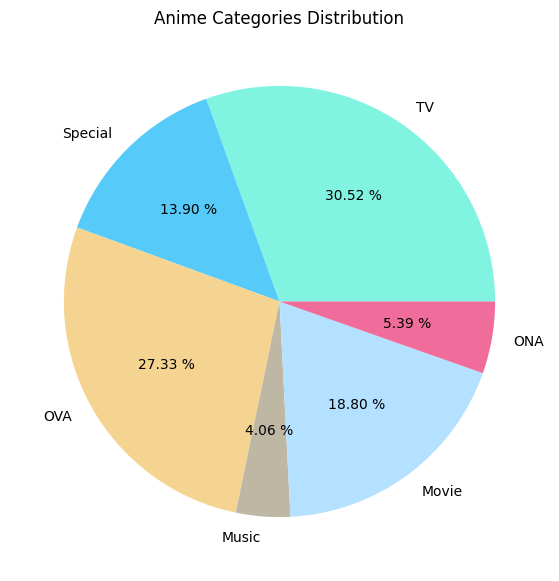

In [ ]:
from pyspark.sql.functions import count, col
import matplotlib.pyplot as plt

# Group anime by type and count the number of each type
anime_type_count = anime.groupby('type').agg(count('*').alias('count'))

# Convert the DataFrame to Pandas to create a pie chart
type_counts = anime_type_count.toPandas()

# Plot the pie chart
labels = type_counts['type']
sizes = type_counts['count']
colors = ['#81F4E1', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B']

plt.figure(figsize=(10,7))
plt.title('Anime Categories Distribution')
plt.pie(sizes,
        labels=labels,
        colors=colors,
        autopct='%.2f %%'
        )

plt.show()


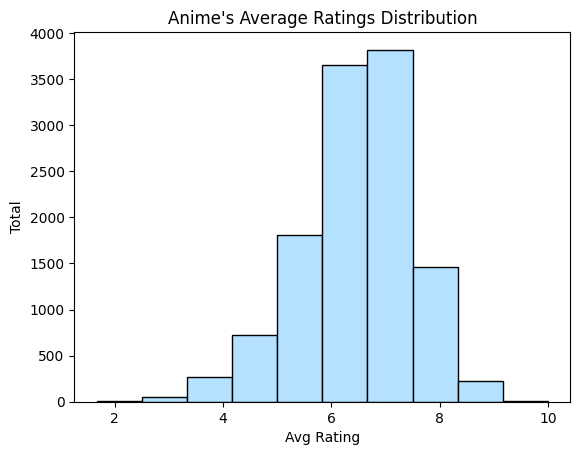

In [ ]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

# Extract the rating column from the anime DataFrame
ratings = anime.select(col("rating")).rdd.flatMap(lambda x: x).collect()

# Create the histogram plot
plt.hist(ratings, color='#B4E1FF', edgecolor='black')
plt.ylabel('Total')
plt.xlabel('Avg Rating')
plt.title("Anime's Average Ratings Distribution")
plt.show()


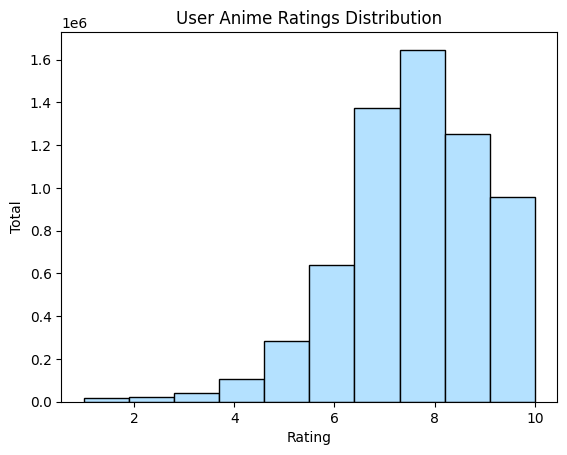

In [ ]:


user_ratings = anime_rating.select('user_id', 'rating')
#Calculate the distribution of ratings

ratings_distribution = user_ratings.groupBy('rating').agg(F.count('user_id').alias('count')).orderBy('rating')
#Convert the result to pandas dataframe

ratings_distribution_df = ratings_distribution.toPandas()
#Plot the histogram

plt.hist(ratings_distribution_df['rating'], weights=ratings_distribution_df['count'], color='#B4E1FF', edgecolor='black')
plt.ylabel('Total')
plt.xlabel('Rating')
plt.title("User Anime Ratings Distribution")
plt.show()

## Multvarite Exploratory Data Analysis

In [ ]:
# import re

# def text_cleaning(text):
#     text = re.sub('<.*?>', '', text)
#     text = re.sub('\n', '', text)
#     text = re.sub('\r', '', text)
#     text = re.sub('\t', '', text)
#     return text.lower()


In [ ]:
from pyspark.sql.functions import desc

anime.orderBy(desc('members')).limit(10).show()


+--------+--------------------+--------------------+----+--------+------+-------+
|anime_id|                name|               genre|type|episodes|rating|members|
+--------+--------------------+--------------------+----+--------+------+-------+
|    1535|          Death Note|Mystery, Police, ...|  TV|      37|  8.71|1013917|
|   16498|  Shingeki no Kyojin|Action, Drama, Fa...|  TV|      25|  8.54| 896229|
|   11757|    Sword Art Online|Action, Adventure...|  TV|      25|  7.83| 893100|
|    5114|Fullmetal Alchemi...|Action, Adventure...|  TV|      64|  9.26| 793665|
|    6547|        Angel Beats!|Action, Comedy, D...|  TV|      13|  8.39| 717796|
|    1575|Code Geass: Hangy...|Action, Mecha, Mi...|  TV|      25|  8.83| 715151|
|      20|              Naruto|Action, Comedy, M...|  TV|     220|  7.81| 683297|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|  TV|      24|  9.17| 673572|
|   10620|    Mirai Nikki (TV)|Action, Mystery, ...|  TV|      26|  8.07| 657190|
|    4224|      

Displays a list of anime with the highest number of community members. For example, the Death Note anime has the highest number of community members, which is 1013917.

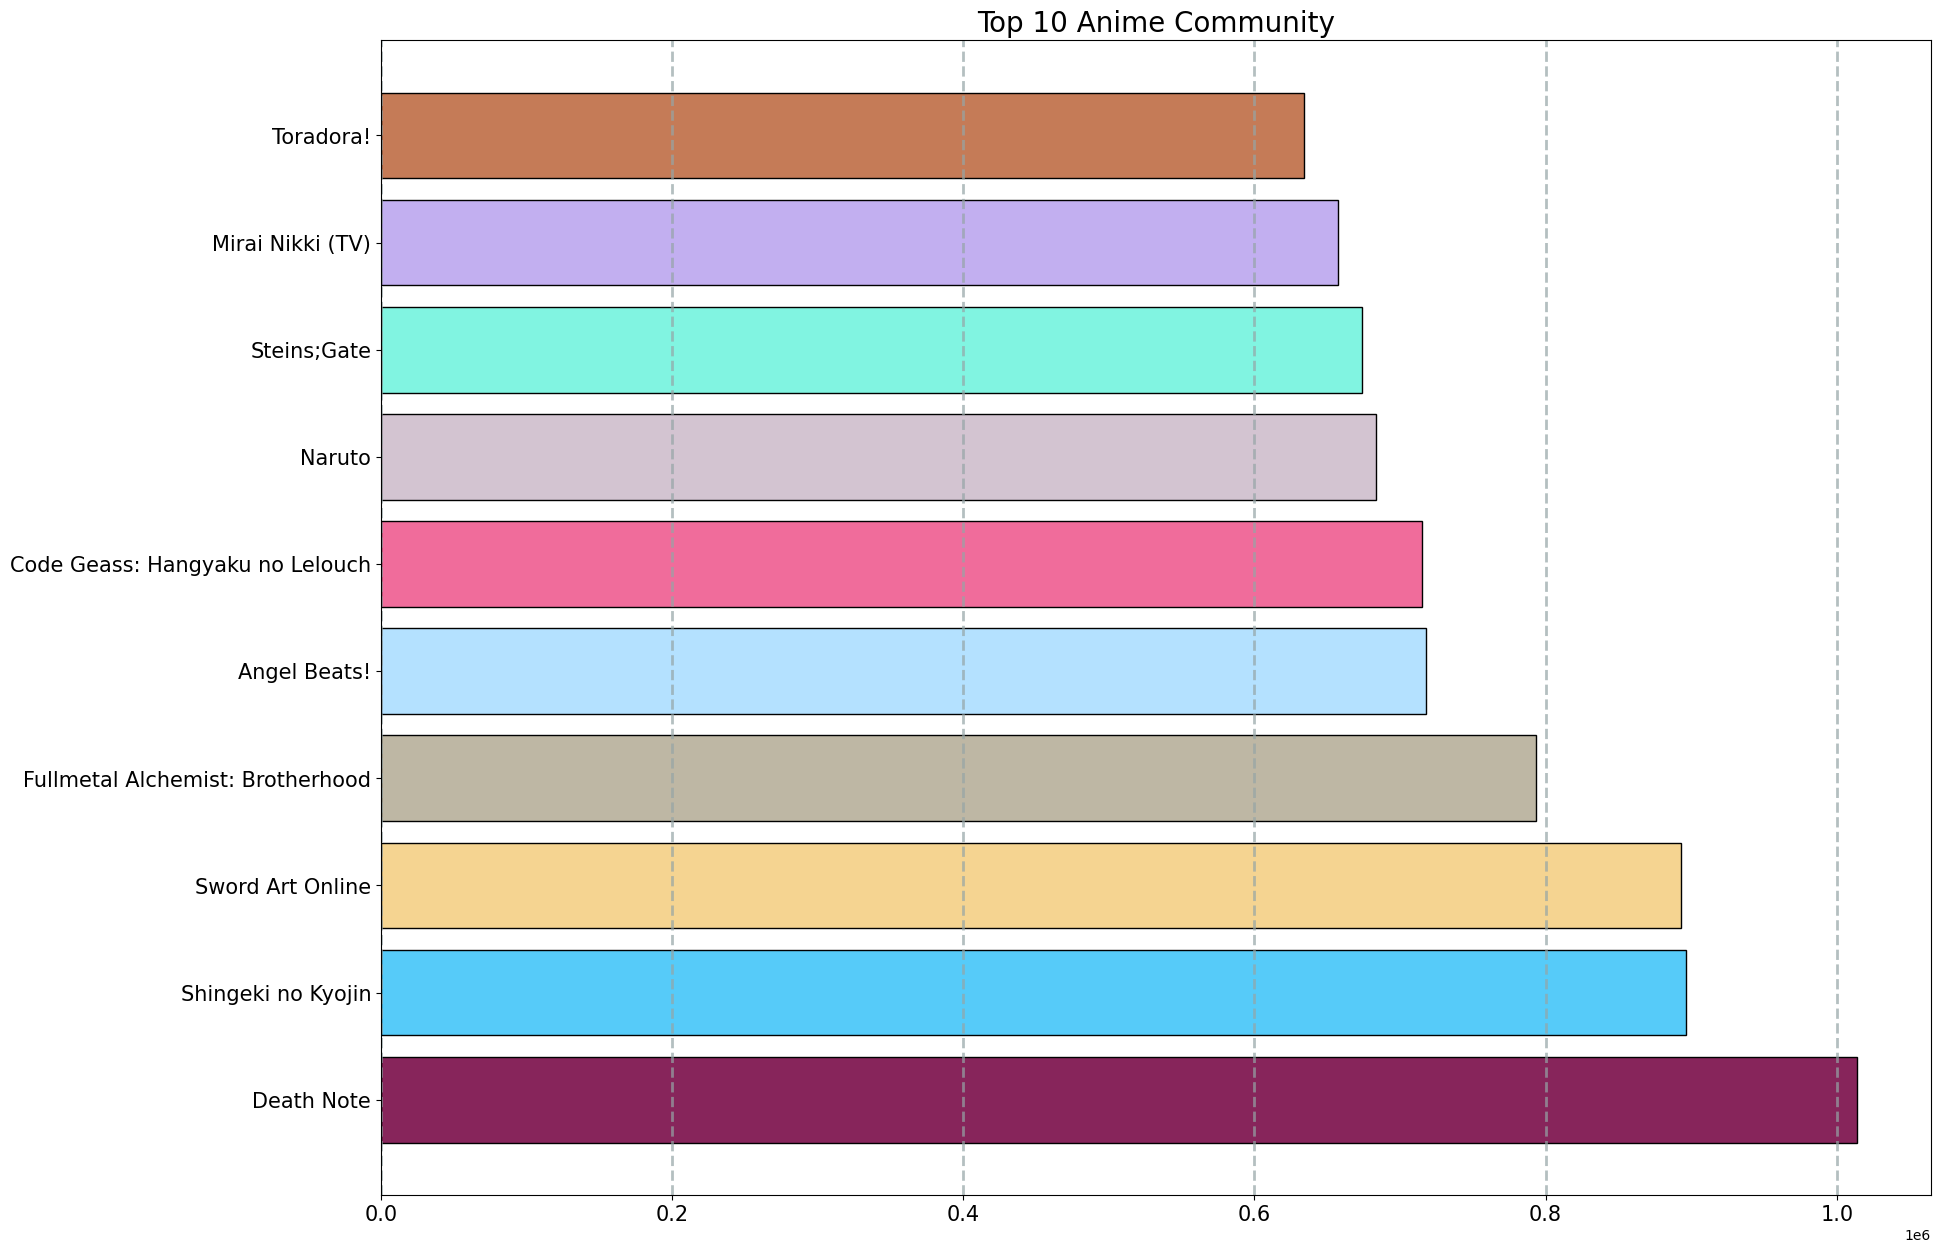

In [ ]:
# Top 10 Anime Community Plot
top10_anime = anime.select("name", "members").orderBy("members", ascending=False).limit(10).toPandas()

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime['name']
values = top10_anime['members']

plt.figure(figsize=(20, 15))
plt.barh(labels, values, color=colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Community", fontdict={'fontsize': 20})
plt.show()


In [ ]:
# Top 10 Anime Based on Avg Ratings
anime.orderBy(desc('rating')).limit(10).show()

+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   33662|Taka no Tsume 8: ...|      Comedy, Parody|Movie|       1|  10.0|     13|
|   30120|Spoon-hime no Swi...|     Adventure, Kids|   TV| Unknown|   9.6|     47|
|   23005|    Mogura no Motoro|       Slice of Life|Movie|       1|   9.5|     62|
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|   33607|        Kahei no Umi|          Historical|Movie|       1|  9.33|     44|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|   26313|Yakusoku: Africa ...|         Drama, Kids|  OVA|       1|  9.25|     53|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|   

Displays anime with the highest average rating. For example, the anime Taka no Tsume 8: Yoshida-kun no X-Files has the highest average rating, which is 10.

In [ ]:
from pyspark.sql import SparkSession

# Create a SparkSession
spark = SparkSession.builder.appName("AnimeRating").getOrCreate()

# Convert the Pandas DataFrame to a Spark DataFrame
rating_spark = spark.createDataFrame(rating)


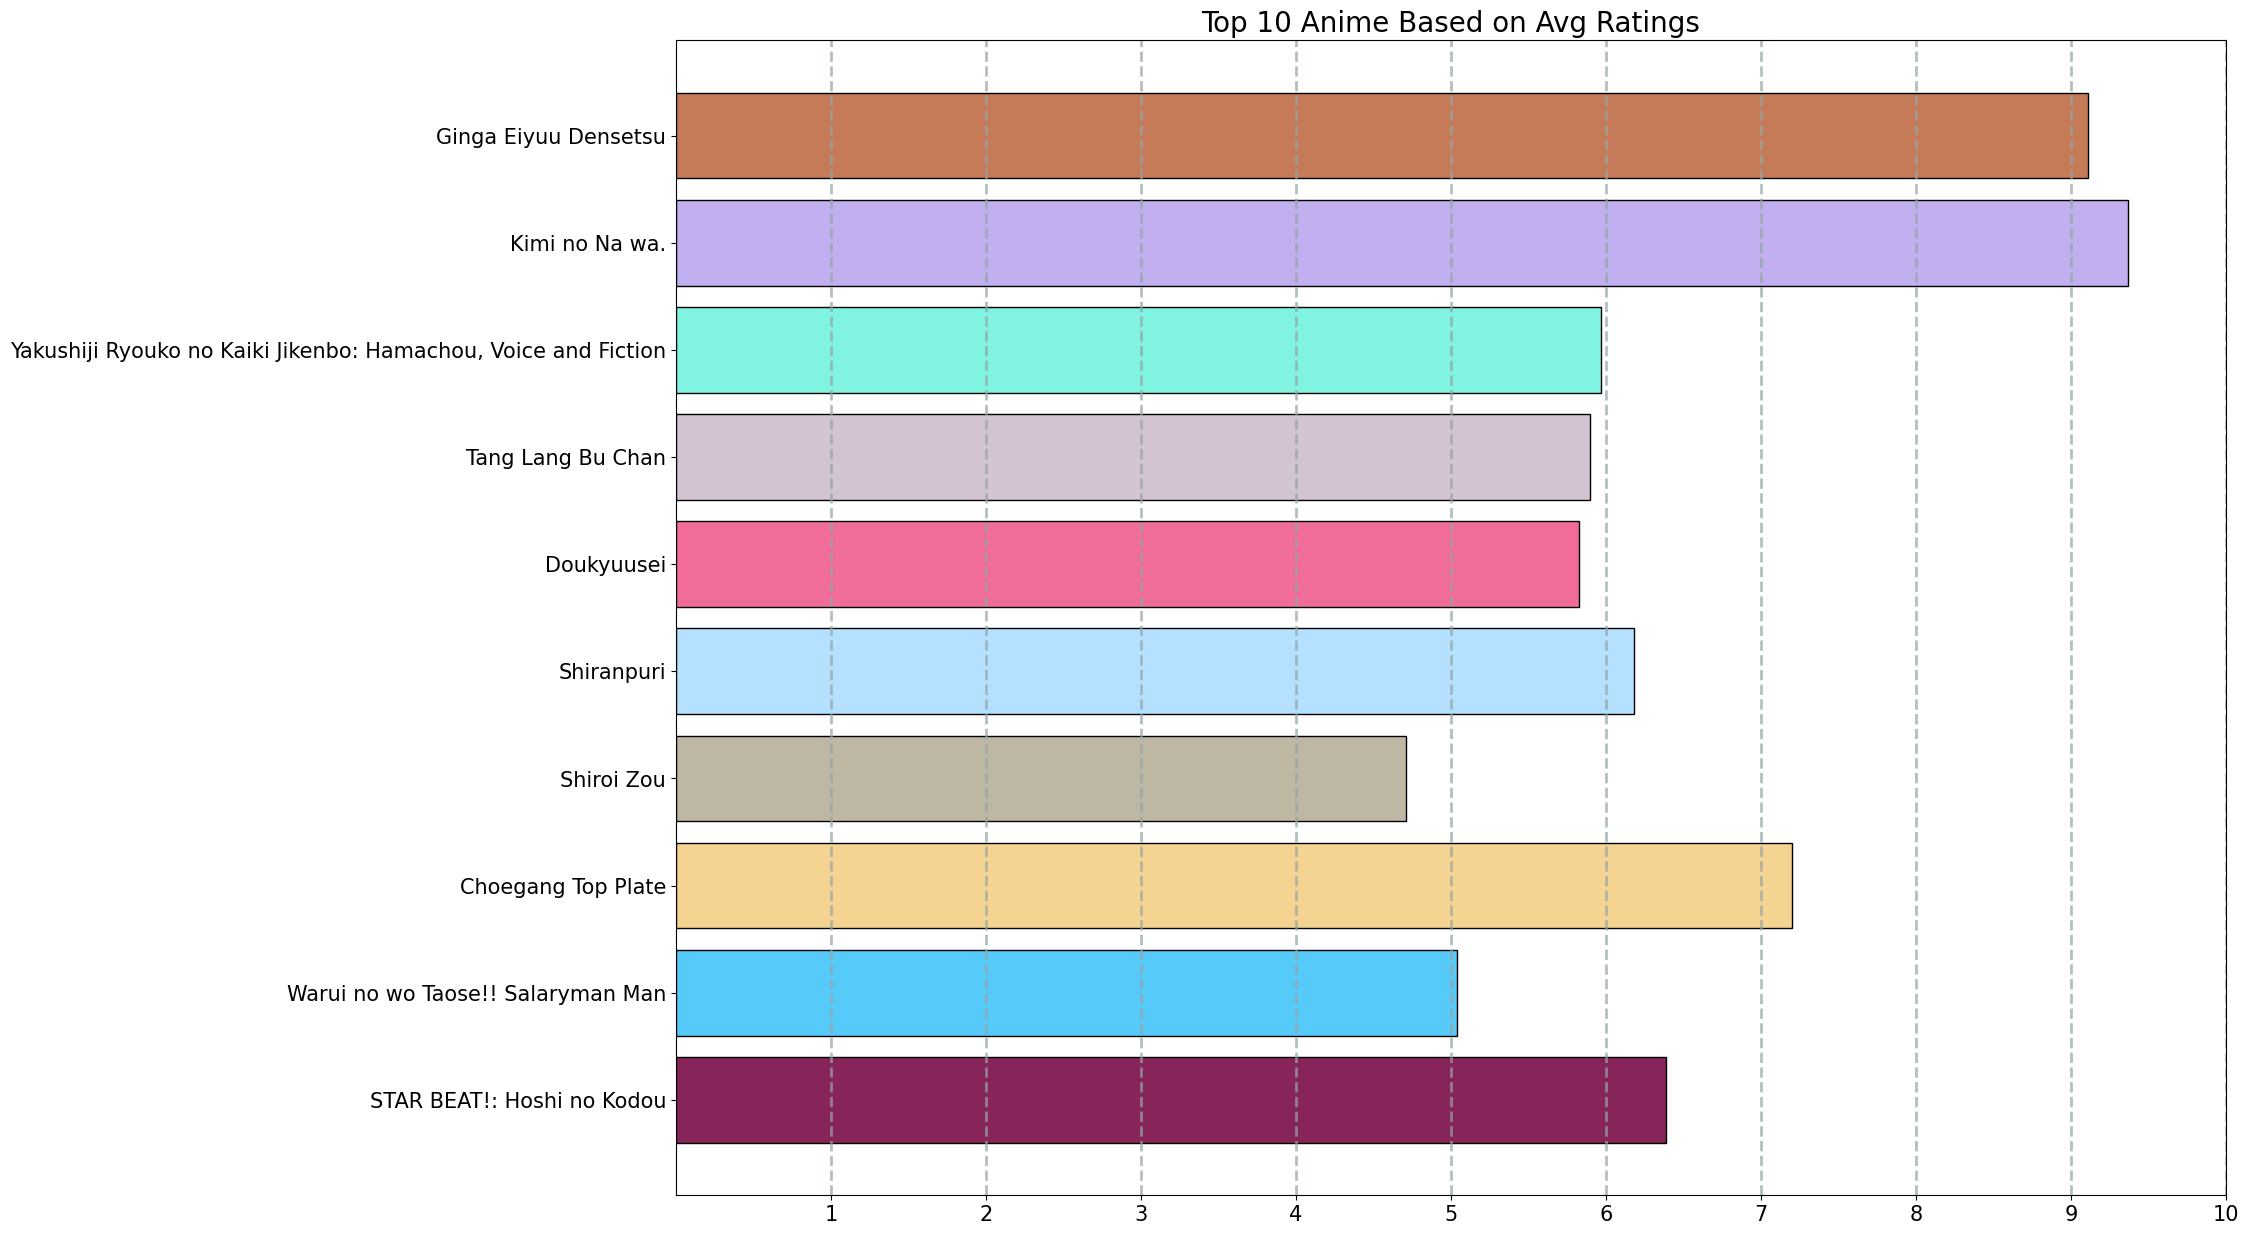

In [ ]:
from pyspark.sql.functions import avg, desc
import matplotlib.pyplot as plt

# Calculate the average rating for each anime
anime_avg_ratings = rating_spark.groupBy("anime_id") \
                         .agg(avg("rating").alias("avg_rating"))

# Join with the anime dataset to get the names
anime_ratings = anime_avg_ratings.join(anime, on="anime_id", how="inner")

# Sort by average rating in descending order and take the top 10
top10_anime = anime_ratings.sort(desc("avg_rating")).limit(10).toPandas()

# Convert top10_anime to a Spark DataFrame
top10_anime_spark = spark.createDataFrame(top10_anime)

# Plot the top 10 anime based on average rating
plt.figure(figsize=(20, 15))
labels = top10_anime_spark.select('name').rdd.flatMap(lambda x: x).collect()
values = top10_anime_spark.select('rating').rdd.flatMap(lambda x: x).collect()
colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
plt.barh(labels, values, color=colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(bins, fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Based on Avg Ratings", fontdict={'fontsize': 20})
plt.show()


In [ ]:
anime_ratings.show(10)

+--------+-----------------+--------------------+--------------------+-------+--------+------+-------+
|anime_id|       avg_rating|                name|               genre|   type|episodes|rating|members|
+--------+-----------------+--------------------+--------------------+-------+--------+------+-------+
|   15437|5.661859582542695|Kore wa Zombie De...|Action, Comedy, E...|    OVA|       1|  7.64|  54828|
|   19163|6.001490066225165|      Date A Live II|Comedy, Harem, Me...|     TV|      10|   7.5| 186187|
|   16742|6.039422610383309|Watashi ga Motena...|Comedy, School, S...|     TV|      12|  7.29| 257925|
|   14719|7.219912035185926|JoJo no Kimyou na...|Action, Adventure...|     TV|      26|  8.51| 190197|
|   31156|4.821192052980132|Kuusen Madoushi K...|Action, Drama, Fa...|    OVA|       1|  6.42|   8632|
|    8440|5.401079136690647|  Black Lagoon Omake|              Comedy|Special|       7|  7.02|  33923|
|    2927|6.133101851851852| Kimikiss Pure Rouge|Drama, Romance, S...|   

In [ ]:
from pyspark.sql.functions import count
# Count anime rating contribution
anime_rating_contribution = anime_rating.groupBy('anime_id').agg(count("*").alias("rating_count"))
anime_rating_contribution.show(3)

+--------+------------+
|anime_id|rating_count|
+--------+------------+
|   24171|          75|
|    1829|        2651|
|   17389|         761|
+--------+------------+
only showing top 3 rows



# Combine the anime rating contribution table with the anime table to get the name of the anime
# Top 10 anime rating contribution



In [ ]:
from pyspark.sql.functions import desc, col

anime2 = anime.drop('rating')
name_anime_rating_contribution = anime_rating_contribution.join(anime2, on='anime_id', how='left')
name_anime_rating_contribution = name_anime_rating_contribution.withColumnRenamed('count', 'rating_count')
name_anime_rating_contribution.sort(desc('rating_count')).show(10)


+--------+------------+--------------------+--------------------+----+--------+-------+
|anime_id|rating_count|                name|               genre|type|episodes|members|
+--------+------------+--------------------+--------------------+----+--------+-------+
|    1535|       34226|          Death Note|Mystery, Police, ...|  TV|      37|1013917|
|   11757|       26310|    Sword Art Online|Action, Adventure...|  TV|      25| 893100|
|   16498|       25289|  Shingeki no Kyojin|Action, Drama, Fa...|  TV|      25| 896229|
|    1575|       24126|Code Geass: Hangy...|Action, Mecha, Mi...|  TV|      25| 715151|
|    6547|       23565|        Angel Beats!|Action, Comedy, D...|  TV|      13| 717796|
|     226|       23528|          Elfen Lied|Action, Drama, Ho...|  TV|      13| 623511|
|      20|       22071|              Naruto|Action, Comedy, M...|  TV|     220| 683297|
|    5114|       21494|Fullmetal Alchemi...|Action, Adventure...|  TV|      64| 793665|
|     121|       21332| Fullmeta

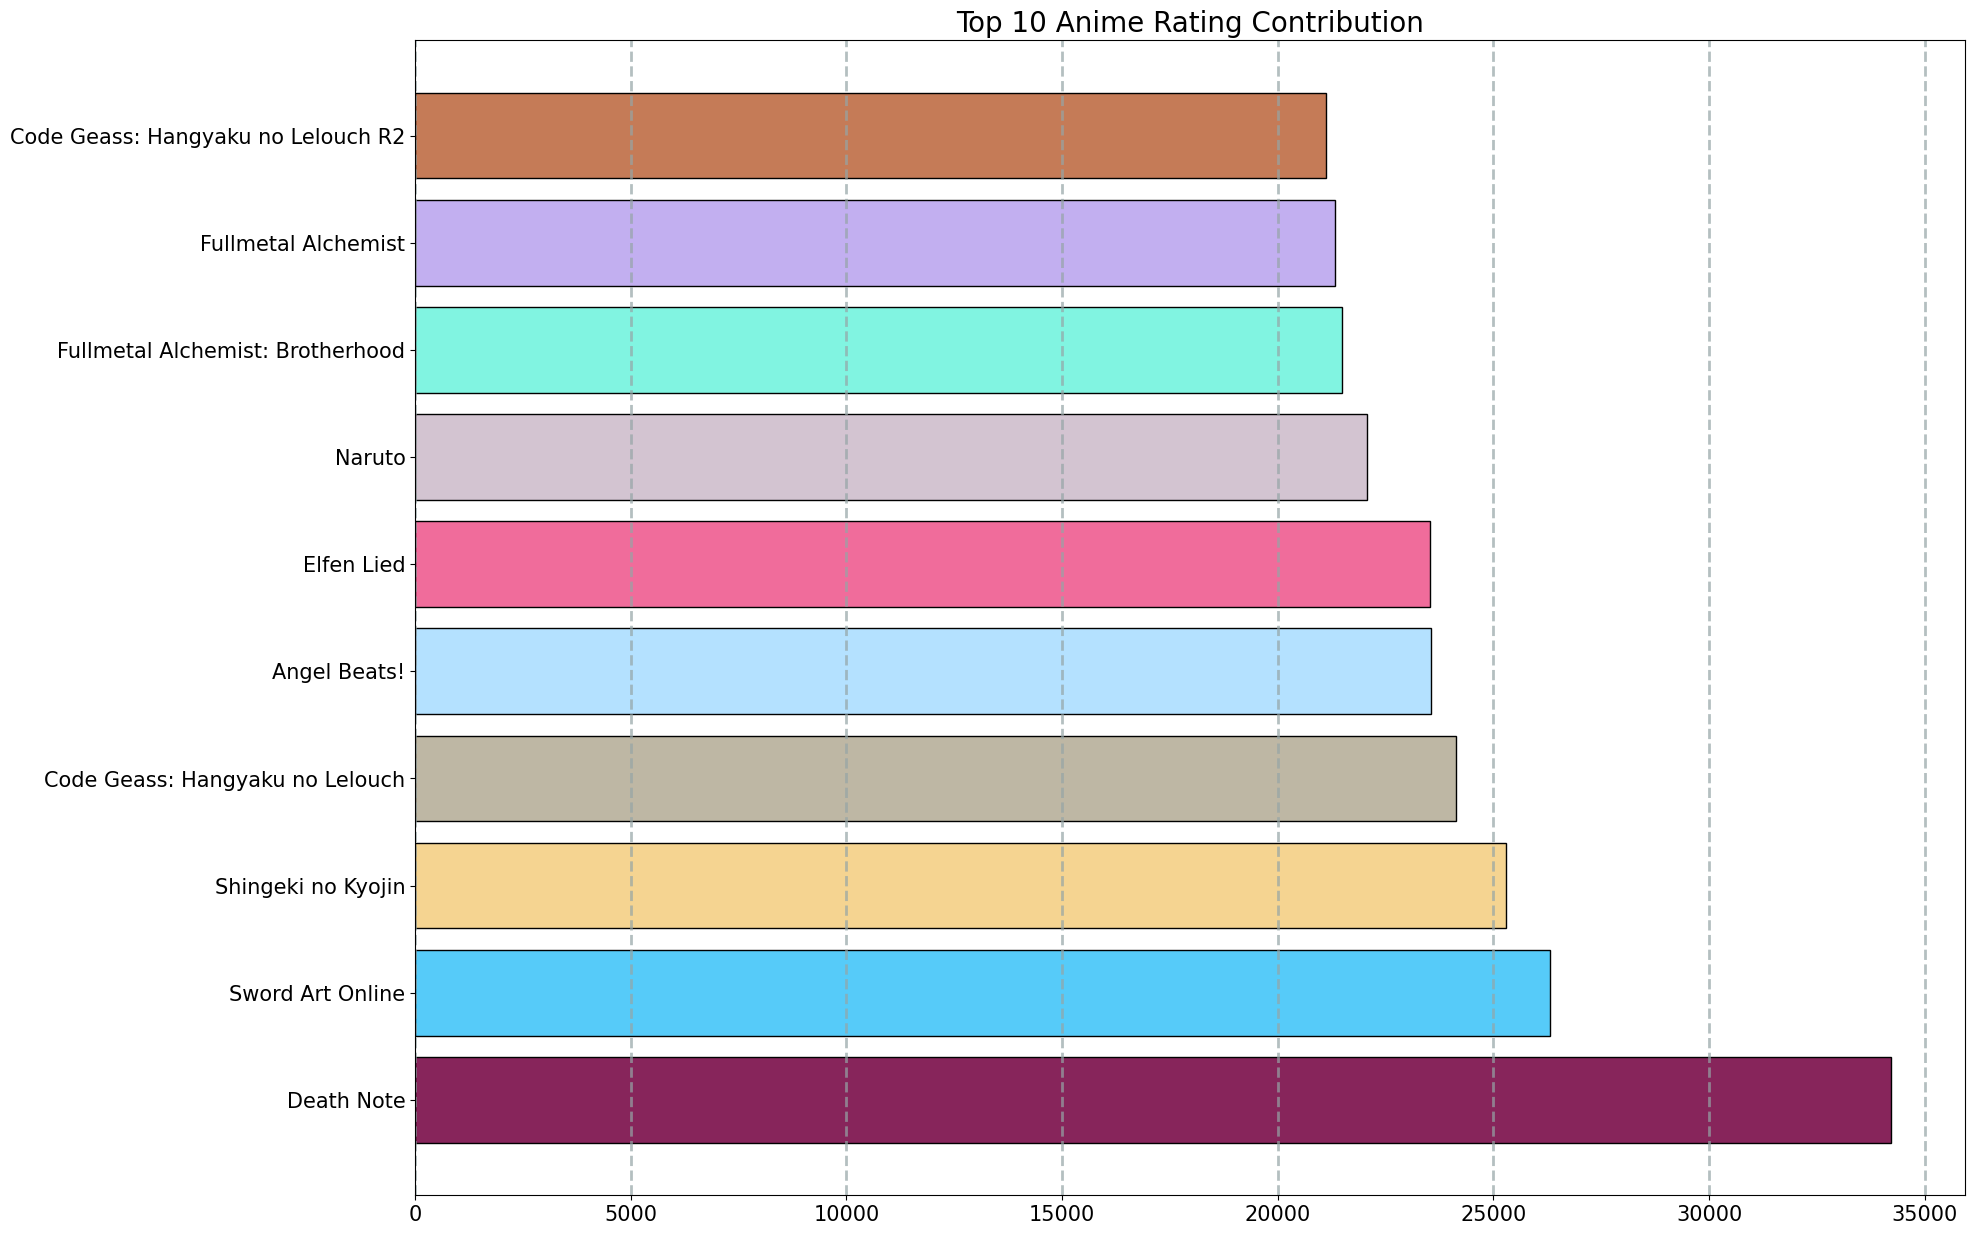

In [ ]:
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

top10_anime = name_anime_rating_contribution.select('name', 'count').sort(F.desc('count')).limit(10).toPandas()

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = top10_anime['name'].values
values = top10_anime['count'].values

plt.figure(figsize=(20, 15))
plt.barh(labels, values, color=colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Rating Contribution", fontdict={'fontsize': 20})
plt.show()


In [ ]:
from pyspark.sql.functions import desc

top_anime = anime.orderBy(desc("rating")).limit(10)
top_anime.show()


+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   33662|Taka no Tsume 8: ...|      Comedy, Parody|Movie|       1|  10.0|     13|
|   30120|Spoon-hime no Swi...|     Adventure, Kids|   TV| Unknown|   9.6|     47|
|   23005|    Mogura no Motoro|       Slice of Life|Movie|       1|   9.5|     62|
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|   33607|        Kahei no Umi|          Historical|Movie|       1|  9.33|     44|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|   26313|Yakusoku: Africa ...|         Drama, Kids|  OVA|       1|  9.25|     53|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|   

Displays anime with the highest average rating. For example, the anime Taka no Tsume 8: Yoshida-kun no X-Files has the highest average rating, which is 10.





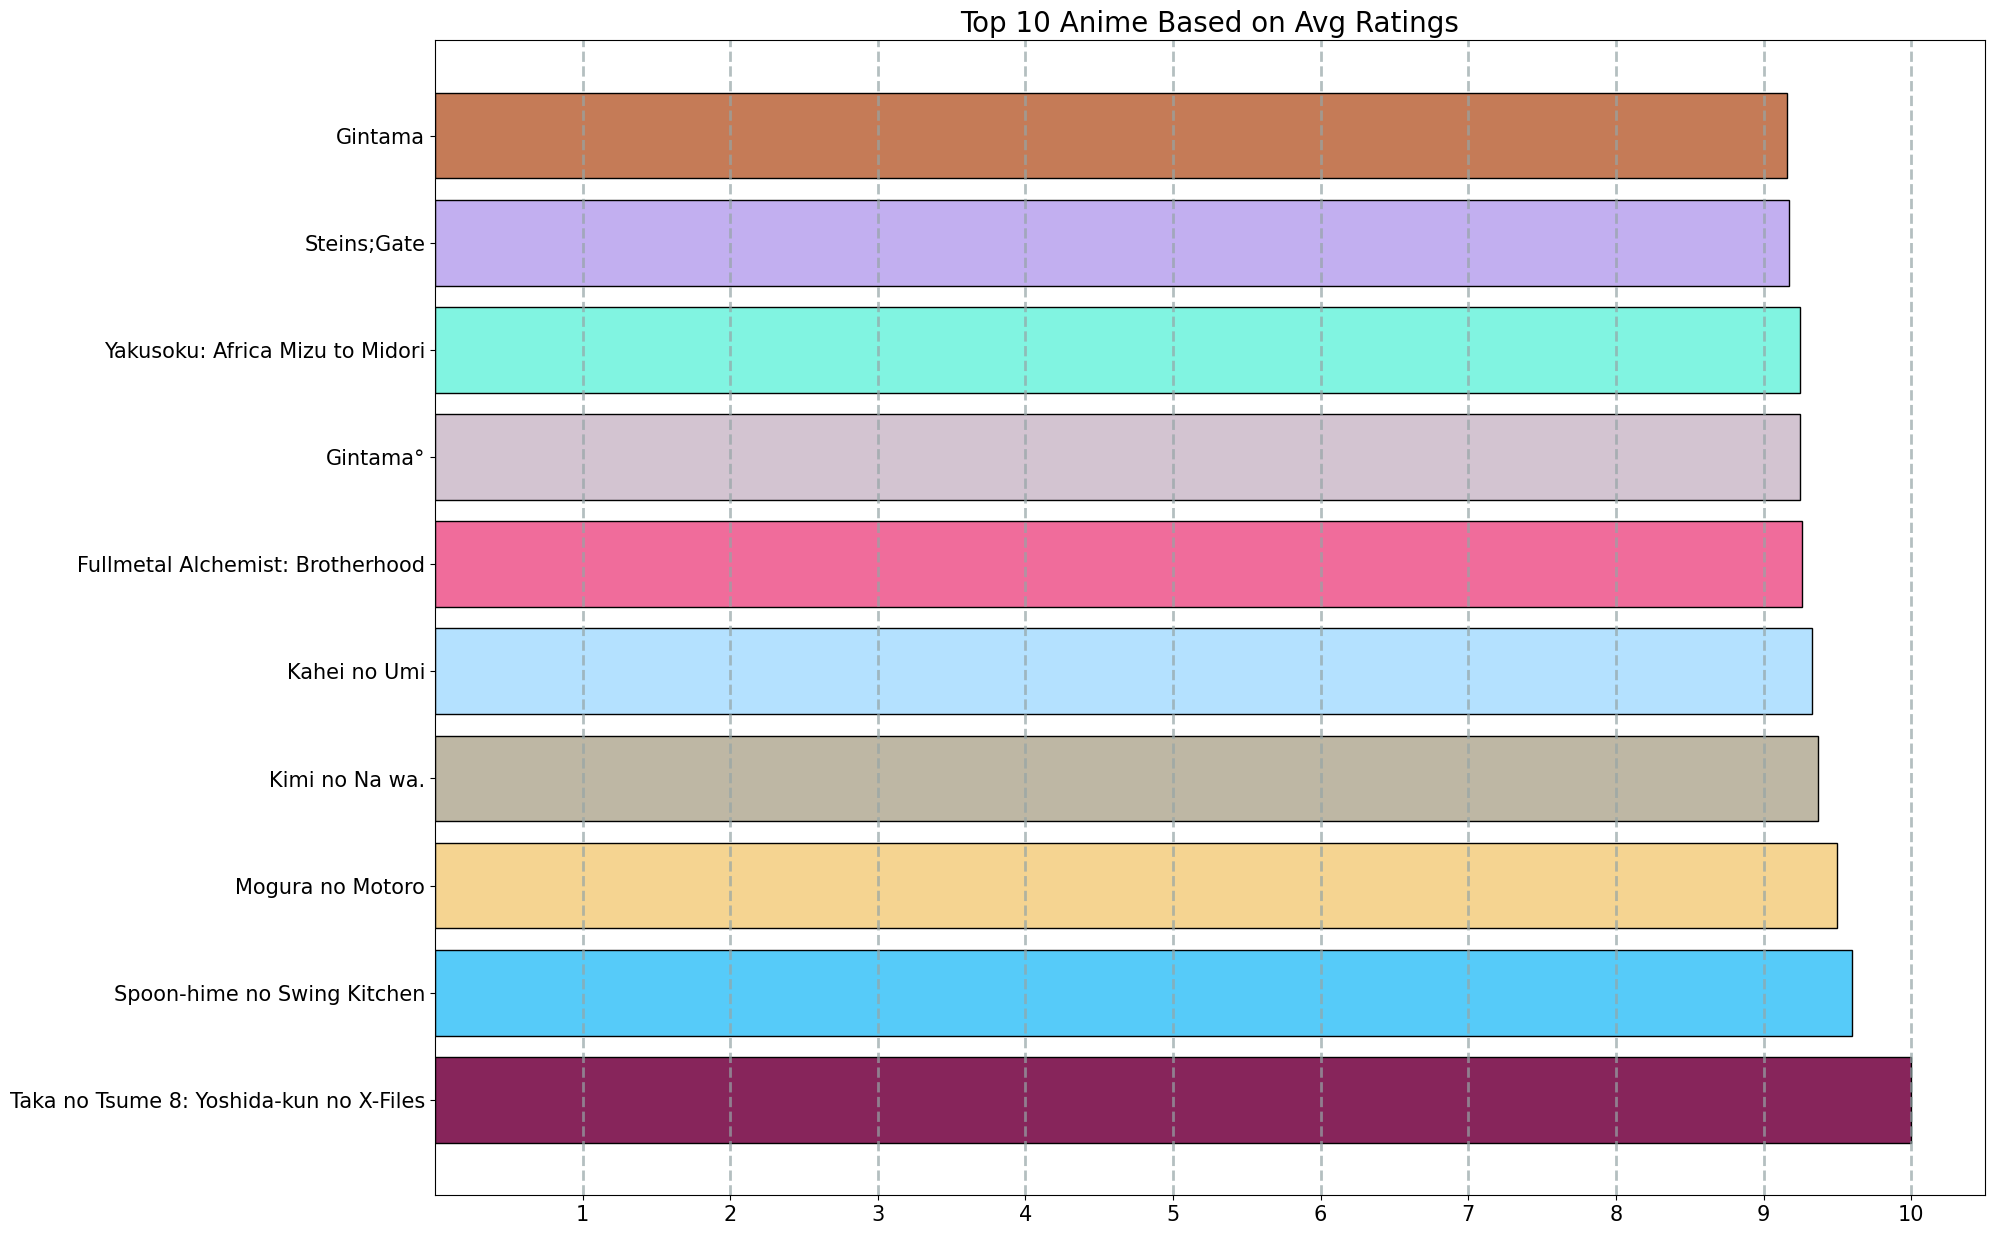

In [ ]:
from pyspark.sql.functions import desc

top10_anime = anime.select('name', 'rating').orderBy(desc('rating')).limit(10).toPandas()

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

labels = top10_anime[['name']].values.flatten()
values = top10_anime[['rating']].values.flatten()

plt.figure(figsize = (20,15))
plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(bins, fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Based on Avg Ratings", fontdict = {'fontsize' : 20})
plt.show()

Taka no Tsume 8 is best anime among average

In [ ]:
from pyspark.sql.functions import count

anime_rating_contribution = anime_rating.groupBy("anime_id").agg(count("*").alias("rating_count"))
anime_rating_contribution.show(3)


+--------+------------+
|anime_id|rating_count|
+--------+------------+
|   24171|          75|
|    1829|        2651|
|   17389|         761|
+--------+------------+
only showing top 3 rows



Anime with ID 24171 has been rated 75 times, anime with ID 1829 has been rated 2651 times, and anime with ID 17389 has been rated 761 times.

In [ ]:
anime

DataFrame[anime_id: int, name: string, genre: string, type: string, episodes: string, rating: double, members: int]

In [ ]:
from pyspark.sql.functions import desc

anime2 = anime.drop('rating')
name_anime_rating_contribution = anime_rating_contribution.join(anime2, on='anime_id', how='left')
name_anime_rating_contribution.show(10)


+--------+------------+--------------------+--------------------+-----+--------+-------+
|anime_id|rating_count|                name|               genre| type|episodes|members|
+--------+------------+--------------------+--------------------+-----+--------+-------+
|   24171|          75|     Mushibugyou OVA|Action, Fantasy, ...|  OVA|       3|   3636|
|    1829|        2651|          Gedo Senki|Adventure, Fantas...|Movie|       1|  59243|
|   17389|         761|  Kingdom 2nd Season|Action, Historica...|   TV|      39|  31234|
|    5300|        3840|Zoku Natsume Yuuj...|Drama, Fantasy, S...|   TV|      13| 114173|
|    9465|        1942|Break Blade 4: Sa...|Action, Fantasy, ...|Movie|       1|  41598|
|   22097|         910|Magi: Sinbad no B...|Action, Adventure...|  OVA|       5|  52351|
|    8086|        3857|Densetsu no Yuush...|Action, Adventure...|   TV|      24| 130689|
|   30654|        2386|Ansatsu Kyoushits...|Action, Comedy, S...|   TV|      25| 176475|
|    1088|        113

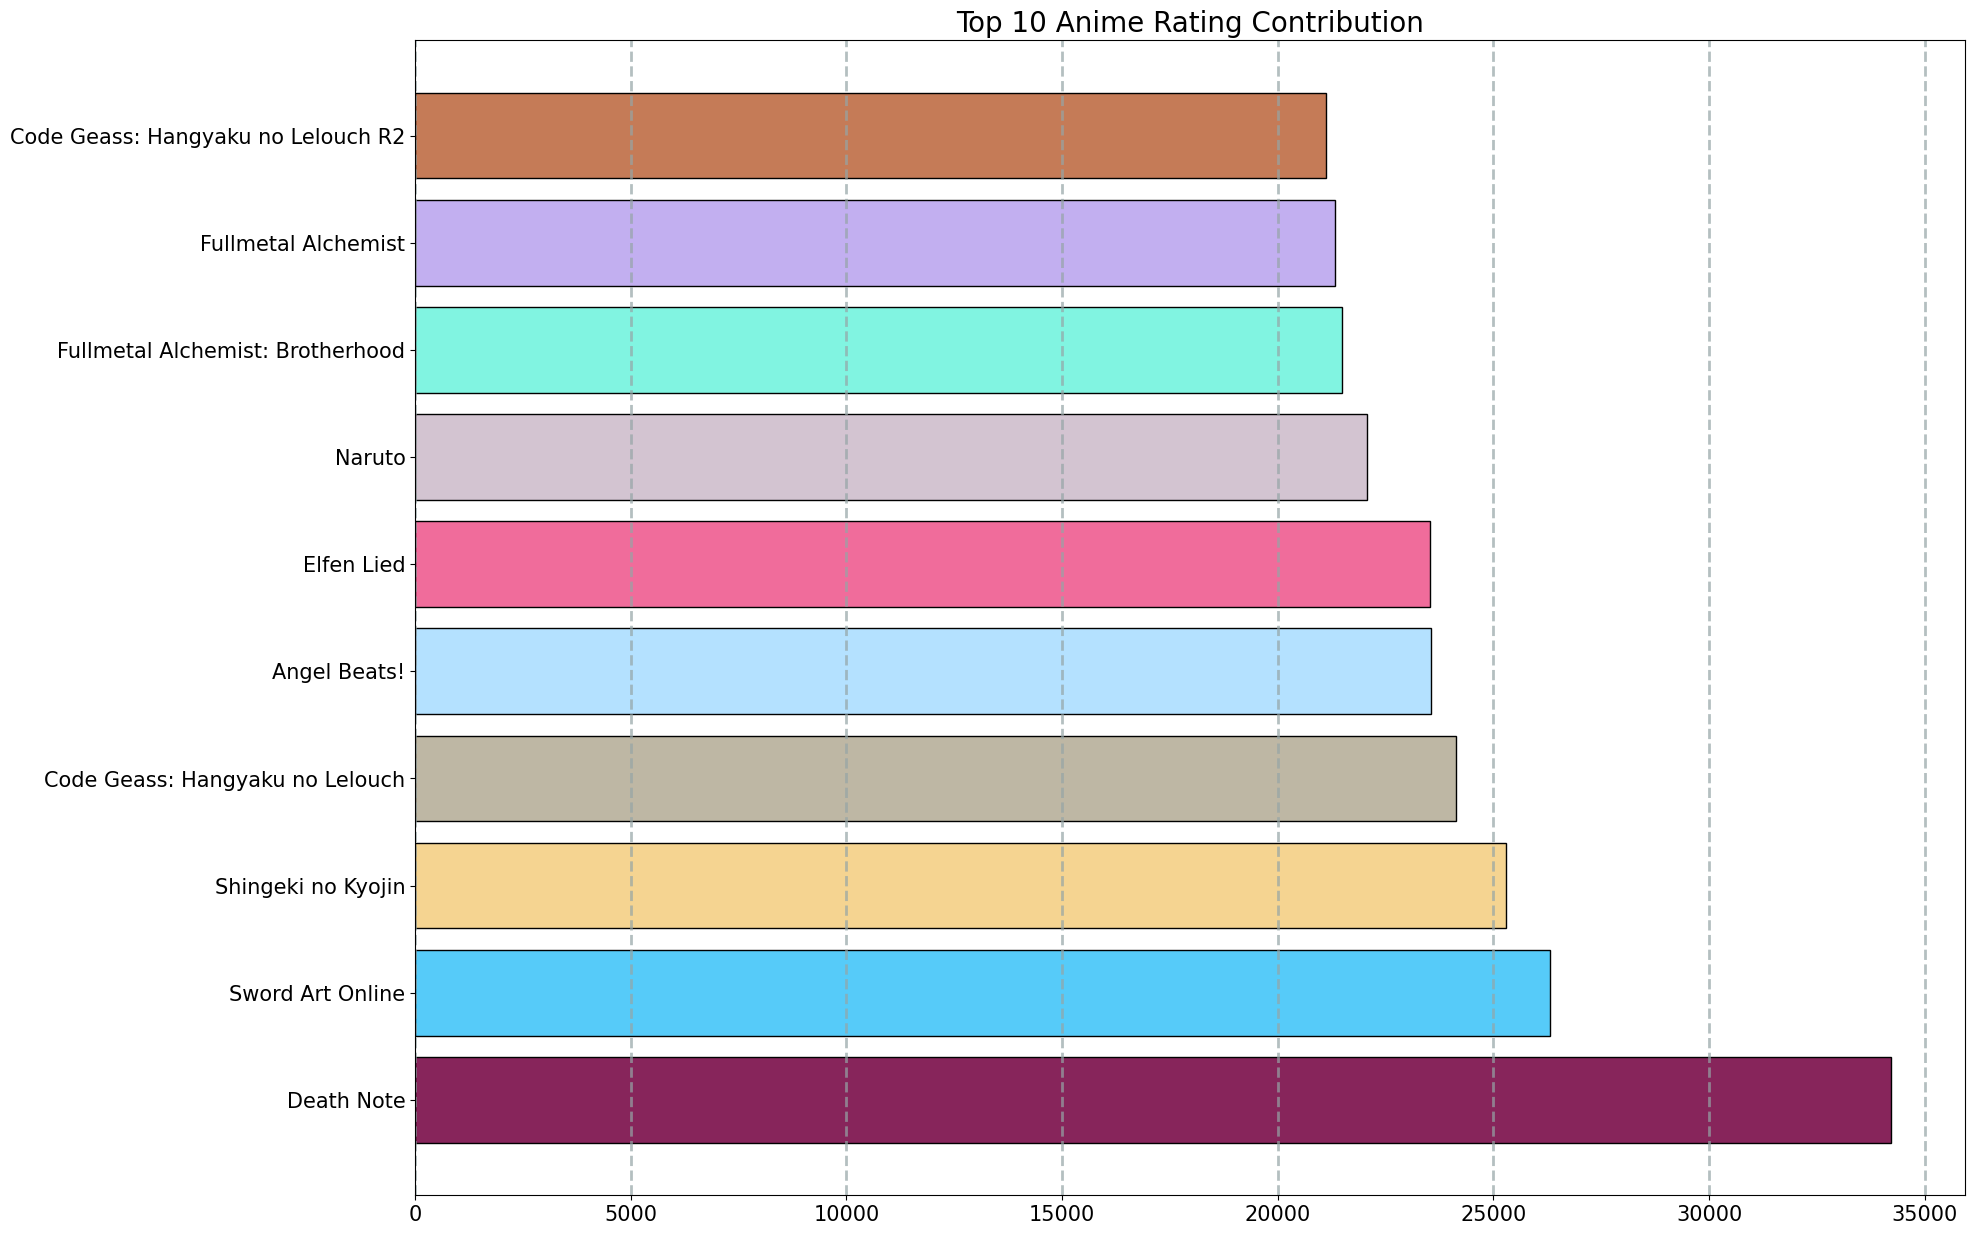

In [ ]:
# Top 10 Anime Rating Contribution Plot
import matplotlib.pyplot as plt
from pyspark.sql.functions import desc

plt.figure(figsize = (20,15))
top10_anime = name_anime_rating_contribution.select('name', 'rating_count').sort(desc('rating_count')).head(10)

colors = ['#87255B', '#56CBF9', '#F5D491', '#BEB7A4', '#B4E1FF', '#F06C9B', '#D3C4D1', '#81F4E1', '#C2AFF0', '#C57B57']

labels = [row.name for row in top10_anime]
values = [row.rating_count for row in top10_anime]

plt.barh(labels, values, color = colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.title("Top 10 Anime Rating Contribution", fontdict = {'fontsize' : 20})
plt.show()


# Content Based Filtering Model & Result

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AnimeRecommendation") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


In [ ]:
import pandas as pd
df_spark = anime.join(anime_rating, on='anime_id', how='left')
# Assume 'df_spark' is the PySpark DataFrame


In [ ]:
df_pandas = df_spark.toPandas()

Py4JJavaError: ignored

In [ ]:
from pyspark.sql.functions import split, col
from pyspark.ml.feature import HashingTF, IDF

# Split the genre column into an array of strings
df_spark = df_spark.withColumn('genre_array', split(col('genre'), ', '))

# Hash the genre array
hashing_tf = HashingTF(inputCol='genre_array', outputCol='raw_features', numFeatures=20)
featurized_data = hashing_tf.transform(df_spark)

# Compute IDF
idf = IDF(inputCol='raw_features', outputCol='features')
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)


['feature_0',
 'feature_1',
 'feature_2',
 'feature_3',
 'feature_4',
 'feature_5',
 'feature_6',
 'feature_7',
 'feature_8',
 'feature_9',
 'feature_10',
 'feature_11',
 'feature_12',
 'feature_13',
 'feature_14',
 'feature_15',
 'feature_16',
 'feature_17',
 'feature_18',
 'feature_19']

In [ ]:
from pyspark.sql.functions import split
from pyspark.ml.feature import CountVectorizer, IDF

# Split the rating column into an array of strings
anime = anime.withColumn("rating", split(anime["rating"], ", "))

# Apply the TfidfVectorizer to the rating column
cv = CountVectorizer(inputCol="rating", outputCol="raw_features", vocabSize=1000, minDF=10.0)
cvmodel = cv.fit(anime)
featurizedData = cvmodel.transform(anime)

idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(featurizedData)
tfidf = idfModel.transform(featurizedData)

# The resulting PySpark DataFrame will have a 'features' column containing the TF-IDF vectors
tfidf.show()


+--------+--------------------+--------------------+-----+--------+------+-------+--------------------+--------------------+--------------------+
|anime_id|                name|               genre| type|episodes|rating|members|           genre_arr|        raw_features|            features|
+--------+--------------------+--------------------+-----+--------+------+-------+--------------------+--------------------+--------------------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|[Drama, Romance, ...|(43,[5,8,10,12],[...|(43,[5,8,10,12],[...|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|[Action, Adventur...|(43,[1,2,3,5,6,16...|(43,[1,2,3,5,6,16...|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|[Action, Comedy, ...|(43,[0,1,4,6,15,2...|(43,[0,1,4,6,15,2...|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|  [Sci-Fi, Thriller]|(43,[4,36],[1.0,1...|

In [ ]:
from pyspark.sql.functions import split, col
from pyspark.ml.feature import HashingTF, IDF

# Split the genre column into an array of strings
df_spark = df_spark.withColumn('genre_array', split(col('genre'), ', '))

# Hash the genre array
hashing_tf = HashingTF(inputCol='genre_array', outputCol='raw_features', numFeatures=20)
featurized_data = hashing_tf.transform(df_spark)

# Compute IDF
idf = IDF(inputCol='raw_features', outputCol='features')
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

# Get the feature column name
feature_col = hashing_tf.getOutputCol()

# Show the feature names
feature_names = [f'feature_{i}' for i in range(20)]
for i, name in enumerate(feature_names):
    print(f"{name}: {idf_model.idf[i]}")


feature_0: 0.5842108871667004
feature_1: 2.948953457519371
feature_2: 0.9321127893817565
feature_3: 7.03658554800555
feature_4: 3.4181932498592063
feature_5: 2.6168006418528895
feature_6: 5.6867917558678105
feature_7: 15.662274335575086
feature_8: 0.7956268178869397
feature_9: 0.9317762945966541
feature_10: 1.4962463523395504
feature_11: 1.832799730326817
feature_12: 1.3585187882320504
feature_13: 3.6320144749260415
feature_14: 2.637550248247831
feature_15: 1.7648327001841166
feature_16: 1.4101198210216472
feature_17: 1.0247054865103835
feature_18: 2.2217438135687613
feature_19: 0.6991029454576683


In [ ]:
from pyspark.ml.feature import HashingTF, IDF
from pyspark.ml.feature import Tokenizer

# Tokenize the genre column into an array of strings
tokenizer = Tokenizer(inputCol='genre', outputCol='genre_array')
df_spark = tokenizer.transform(df_spark)

# Hash the genre array
hashing_tf = HashingTF(inputCol='genre_array', outputCol='raw_features', numFeatures=20)
featurized_data = hashing_tf.transform(df_spark)

# Compute IDF
idf = IDF(inputCol='raw_features', outputCol='features')
idf_model = idf.fit(featurized_data)
rescaled_data = idf_model.transform(featurized_data)

# View the feature names
vocab = hashing_tf.getOrCreate().getInputCol() + '_vocab'
features = idf_model.idf.toArray()
feature_names = spark.createDataFrame([(i,) for i in range(len(features))], ['id'])
vocab_df = featurized_data.select(vocab).distinct().withColumnRenamed(vocab, 'feature')
feature_names = feature_names.join(vocab_df, feature_names.id == vocab_df.id).select('feature')
feature_names.show()


IllegalArgumentException: ignored

In [ ]:
anime = pd.read_csv('/content/drive/MyDrive/anime.csv')
anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
!pip install scikit-surprise

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate, train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Load the dataset
anime = pd.read_csv('/content/drive/MyDrive/anime.csv')

# Replace missing ratings with 0
anime['rating'].fillna(0, inplace=True)

# Convert genres to lowercase and fill missing values with empty string
anime['genre'] = anime['genre'].str.lower().fillna('')


In [ ]:
# Create a TF-IDF matrix of genres
tf = TfidfVectorizer()
tfidf_matrix = tf.fit_transform(anime['genre'])

# Use K-Means clustering to group similar anime
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(tfidf_matrix)

# Add the cluster labels to the dataset
anime['cluster'] = clusters

# Load the ratings dataset
ratings = pd.read_csv('/content/drive/MyDrive/rating.csv')

# Set up the Surprise dataset
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(ratings[['user_id', 'anime_id', 'rating']], reader)

# Split the dataset into training and testing sets
trainset, testset = train_test_split(data, test_size=.25)

# Train an SVD model on the training set
model = SVD()
model.fit(trainset)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def recommend_collab(anime_name, n=10):
    # Get the anime ID
    anime_id = anime.loc[anime['name']==anime_name, 'anime_id'].values[0]
    
    # Get the predicted ratings for the user and all anime
    anime_preds = []
    for i in range(anime['anime_id'].max()):
        anime_preds.append(model.predict(uid=0, iid=i))
    
    # Sort the anime by predicted rating
    top_n = pd.DataFrame(anime_preds, columns=['uid', 'iid', 'r_ui', 'est', 'details'])
    top_n = top_n.loc[top_n['iid']!=anime_id].nlargest(n, 'est')
    
    # Get the names of the top anime
    top_n['name'] = anime.loc[anime['anime_id'].isin(top_n['iid']), 'name'].values
    
    return top_n[['name', 'est']]

In [ ]:
anime_name = 'Fullmetal Alchemist: Brotherhood'
recommend_collab(anime_name)


,name,est
9253,Kimi no Na wa.,7.865184
32281,Steins;Gate,7.820614
820,Gintama&#039;,7.753199
11061,Hunter x Hunter (2011),7.662054
2001,Ginga Eiyuu Densetsu,7.640575
918,Clannad: After Story,7.542052
9969,Gintama,7.504994
1535,Code Geass: Hangyaku no Lelouch R2,7.498679
2904,Tengen Toppa Gurren Lagann,7.477027
4181,Death Note,7.474357


In [ ]:
from surprise.model_selection import cross_validate
from surprise import accuracy

# Train and evaluate the model using 5-fold cross-validation
model = SVD()
cv_results = cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Get the average RMSE and MAE values across all folds
print('Average RMSE:', round(cv_results['test_rmse'].mean(), 3))
print('Average MAE:', round(cv_results['test_mae'].mean(), 3))


ModuleNotFoundError: ignored